# Sign Language Prediction


## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import string
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

## Download Dataset


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ankitvashisht12","key":"db3fab7267aea91cd64d144e98bf7b35"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d datamunge/sign-language-mnist

 91% 57.0M/62.6M [00:02<00:00, 21.1MB/s]
100% 62.6M/62.6M [00:02<00:00, 29.6MB/s]


## Unzip Dataset

In [6]:
import os

In [7]:
os.listdir()

['.config', 'sign-language-mnist.zip', 'kaggle.json', 'sample_data']

In [8]:
from zipfile import ZipFile
with ZipFile('sign-language-mnist.zip') as z:
  z.extractall('./dataset/')
  print("Done Extraction !")

Done Extraction !


In [9]:
os.listdir('dataset')

['amer_sign3.png',
 'amer_sign2.png',
 'sign_mnist_train',
 'american_sign_language.PNG',
 'sign_mnist_test',
 'sign_mnist_train.csv',
 'sign_mnist_test.csv']

## Explore Dataset

In [10]:
TRAIN_CSV = './dataset/sign_mnist_train.csv'
TEST_CSV = './dataset/sign_mnist_test.csv'

!head {TRAIN_CSV}

label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixe

In [11]:
train_csv_df = pd.read_csv(TRAIN_CSV)
train_csv_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [12]:
!head {TEST_CSV}

label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixe

In [13]:
test_csv_df = pd.read_csv(TEST_CSV)
test_csv_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [14]:
TRAIN_DIR = './dataset/sign_mnist_train/'
os.listdir(TRAIN_DIR)

['sign_mnist_train.csv']

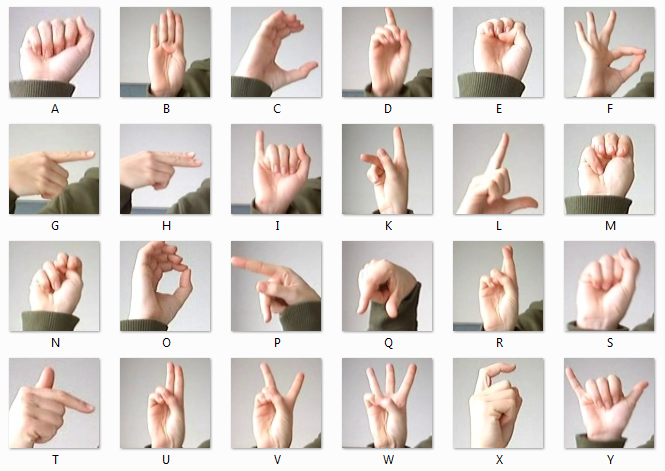

In [15]:
Image.open('./dataset/amer_sign2.png')

In [135]:
A_I = {v:k for k,v in zip(string.ascii_uppercase[:10], range(0,9))}
K_Y = {v:k for k,v in zip(string.ascii_uppercase[10:25], range(9,24))}
LABELS = {**A_I, **K_Y}
LABELS

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'K',
 10: 'L',
 11: 'M',
 12: 'N',
 13: 'O',
 14: 'P',
 15: 'Q',
 16: 'R',
 17: 'S',
 18: 'T',
 19: 'U',
 20: 'V',
 21: 'W',
 22: 'X',
 23: 'Y'}

## Creating Custom Dataset




In [17]:
class CustomDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform 
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx].values
    img = np.uint8(np.array(row[1:]))
    img = np.reshape(img, (28, 28))
    #img = Image.fromarray(np.uint8(img))
    if self.transform:
      img = self.transform(img)
    label = row[0]
    return img, label

In [18]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
dataset = CustomDataset(train_csv_df, transform=transform)
dataset

torch.Size([1, 28, 28]) C


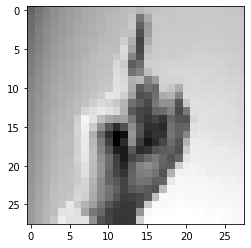

In [19]:
img, label = dataset[0]
print(img.shape, LABELS[label])
plt.imshow(img[0], cmap='gray')

## Creating training and validation dataset

In [74]:
random_seed = 42
torch.manual_seed(random_seed);

In [75]:
val_pct = 0.15
val_size = int(len(train_csv_df)*val_pct)
train_size = len(train_csv_df) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(23337, 4118)

## Creating DataLoader


In [76]:
batch_size = 128
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=2, pin_memory=True)

In [77]:
for img, label in train_dl:
  print("image shape :", img.shape)
  print("label :", label)
  break

image shape : torch.Size([128, 1, 28, 28])
label : tensor([ 3, 16,  2, 16, 12, 22, 21,  2, 13, 19, 12, 15, 14, 11, 17, 13, 11, 17,
        20, 19,  6,  3, 18, 14, 18, 15, 23,  6, 16, 10,  1, 23, 11, 12, 15, 15,
        11,  5,  0, 23,  1, 23, 14, 21,  1,  6, 14, 14, 21,  3, 23, 21,  6,  2,
        10, 16, 21, 13,  6,  2, 11, 15, 16,  5, 21,  4,  4, 15, 23, 14, 14, 22,
        12,  2,  6, 11, 22,  5, 18, 21, 14, 13, 13, 17, 10,  4, 19, 11,  1,  2,
         8,  2, 10, 16, 10,  7,  0, 10,  7, 11, 17,  7,  4, 11, 23, 12, 22, 13,
        13,  1, 20, 13, 21, 20, 12, 16, 15,  0, 18,  0,  6, 11, 24, 20, 12,  2,
         5,  2])


In [78]:
def show_batch(dl):
  for img, lable in train_dl:
    print("Labels :",label)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

Labels : tensor([ 3, 16,  2, 16, 12, 22, 21,  2, 13, 19, 12, 15, 14, 11, 17, 13, 11, 17,
        20, 19,  6,  3, 18, 14, 18, 15, 23,  6, 16, 10,  1, 23, 11, 12, 15, 15,
        11,  5,  0, 23,  1, 23, 14, 21,  1,  6, 14, 14, 21,  3, 23, 21,  6,  2,
        10, 16, 21, 13,  6,  2, 11, 15, 16,  5, 21,  4,  4, 15, 23, 14, 14, 22,
        12,  2,  6, 11, 22,  5, 18, 21, 14, 13, 13, 17, 10,  4, 19, 11,  1,  2,
         8,  2, 10, 16, 10,  7,  0, 10,  7, 11, 17,  7,  4, 11, 23, 12, 22, 13,
        13,  1, 20, 13, 21, 20, 12, 16, 15,  0, 18,  0,  6, 11, 24, 20, 12,  2,
         5,  2])


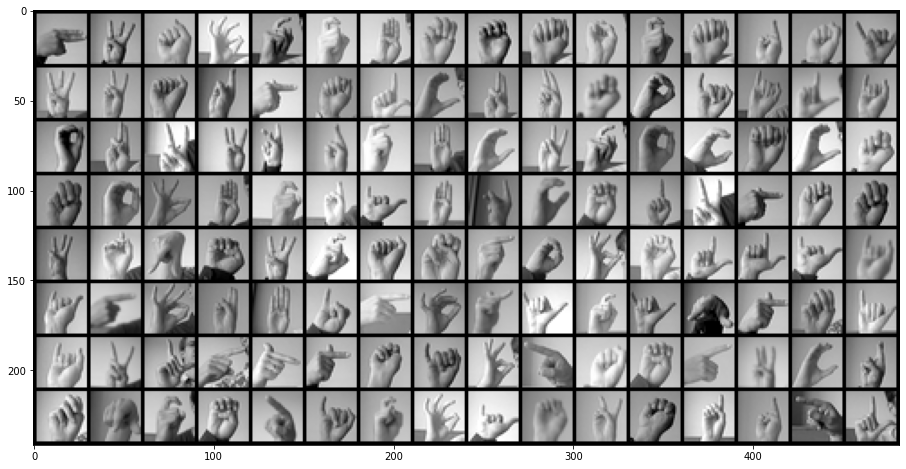

In [79]:
show_batch(train_dl)

## Model


In [107]:
class ImageClassificationBase(nn.Module):
  def training_step(self, data):
    images, targets = data
    outs = self(images)
    loss = F.cross_entropy(outs, targets)
    return loss
  
  def validation_step(self, data):
    images, targets = data
    outs = self(images)
    loss = F.cross_entropy(outs, targets)
    acc = accuracy(outs , targets)
    return {"val_acc":acc.detach(), "val_loss":loss.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_scores = [x['val_acc'] for x in outputs]
    epoch_scores = torch.stack(batch_scores).mean()
    return {'val_loss':epoch_losses.item(), 'val_score':epoch_scores.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch,  result['val_loss'], result['val_score']))


In [95]:
class SignLangClassifier(ImageClassificationBase):
  def __init__(self):
    super().__init__()

    self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 3 x 3
           
            nn.Flatten(),
            nn.Linear(256*3*3, 512),
            nn.ReLU(),
            nn.Linear(512, 24)     

    )
  def forward(self, xb):
    return self.network(xb)

In [96]:
model = SignLangClassifier()

In [97]:
model

SignLangClassifier(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=2304, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_feature

## Moving Data to GPU

In [98]:
# helper functions

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)

In [99]:
class DeviceDataLoader:
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

In [100]:
device = get_default_device()
device

device(type='cuda')

In [101]:
# move train and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# move model to gpu
to_device(model, device)

SignLangClassifier(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=2304, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_feature

In [102]:
def try_batch(dl):
  for images, labels in dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [103]:
try_batch(train_dl)

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 24])
out[0]: tensor([ 1.8559e-02,  1.8259e-02,  2.6361e-02,  2.4849e-02, -8.6676e-03,
         1.0594e-05,  1.1290e-02,  3.4077e-02,  1.0086e-02,  3.7803e-02,
        -1.5389e-02,  1.9390e-02, -9.2669e-04, -5.3203e-03,  3.5523e-02,
        -5.0934e-03,  2.0130e-02,  2.4013e-02, -3.2560e-02,  4.1589e-02,
         1.0032e-02,  3.7260e-02, -3.3462e-02, -2.4506e-02], device='cuda:0',
       grad_fn=<SelectBackward>)


## Training model

In [104]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [105]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [108]:
evaluate(model, val_dl)

{'val_loss': 3.1785881519317627, 'val_score': 0.03584558889269829}

In [109]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [110]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 3.1201, val_score: 0.0446
Epoch [1], val_loss: 0.5961, val_score: 0.7979
Epoch [2], val_loss: 0.2110, val_score: 0.9609
Epoch [3], val_loss: 0.1861, val_score: 0.9639
Epoch [4], val_loss: 0.1946, val_score: 0.9575
Epoch [5], val_loss: 0.1667, val_score: 0.9655
Epoch [6], val_loss: 0.1799, val_score: 0.9608
Epoch [7], val_loss: 0.1762, val_score: 0.9605
Epoch [8], val_loss: 0.1593, val_score: 0.9646
Epoch [9], val_loss: 0.1643, val_score: 0.9653


In [113]:
history

[{'train_loss': 3.1302058696746826,
  'val_loss': 3.1201112270355225,
  'val_score': 0.04463987424969673},
 {'train_loss': 2.277780294418335,
  'val_loss': 0.5961195826530457,
  'val_score': 0.7979194521903992},
 {'train_loss': 0.31713438034057617,
  'val_loss': 0.21098922193050385,
  'val_score': 0.9609375},
 {'train_loss': 0.21751299500465393,
  'val_loss': 0.18610528111457825,
  'val_score': 0.9639246463775635},
 {'train_loss': 0.20867860317230225,
  'val_loss': 0.19458657503128052,
  'val_score': 0.9574908018112183},
 {'train_loss': 0.1985255479812622,
  'val_loss': 0.16667784750461578,
  'val_score': 0.9655330777168274},
 {'train_loss': 0.19698995351791382,
  'val_loss': 0.1798904687166214,
  'val_score': 0.960791289806366},
 {'train_loss': 0.19335782527923584,
  'val_loss': 0.1761789321899414,
  'val_score': 0.9604779481887817},
 {'train_loss': 0.19104625284671783,
  'val_loss': 0.15928703546524048,
  'val_score': 0.9646139740943909},
 {'train_loss': 0.18938390910625458,
  'val_l

In [114]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

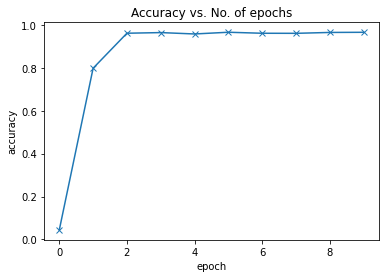

In [118]:
plot_accuracies(history)

In [116]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

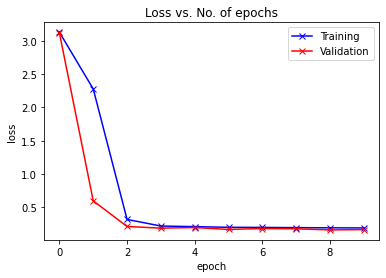

In [117]:
plot_losses(history)

## Testing Model

In [119]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
test_dataset = CustomDataset(test_csv_df, transform=transform)
test_dataset

In [120]:
len(test_dataset)

7172

In [136]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return LABELS[preds[0].item()]

Actual Label : G Predicted Label : G


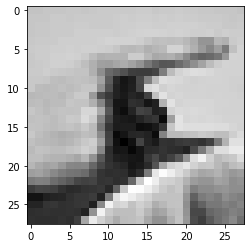

In [137]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap="gray")
print("Actual Label :", LABELS[label], "Predicted Label :", predict_image(img, model))

Actual Label : A Predicted Label : A


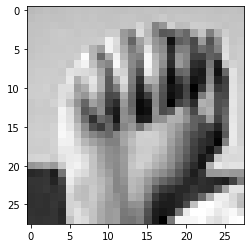

In [140]:
img, label = test_dataset[3]
plt.imshow(img[0], cmap="gray")
print("Actual Label :", LABELS[label], "Predicted Label :", predict_image(img, model))

In [141]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.3174605667591095, 'val_score': 0.9027478694915771}

## Saving and loading the model


In [142]:
torch.save(model.state_dict(), 'sign-lang-classifier.pth')

In [143]:
os.listdir()

['.config',
 'sign-language-mnist.zip',
 'dataset',
 'sign-lang-classifier.pth',
 'kaggle.json',
 'sample_data']